In [1]:
import pandas as pd
import uproot
import cupy as cp
import boost_histogram as bh
import numpy as np
import time
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode']=True
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
P0 = "/home/centos/FlatComplete/eplus_hits_dn_0.root"
E0 = "/home/centos/ElectronDataset/Hits/eminus_hits_dn_0.root"

In [3]:
positron = uproot.open(P0)
electron = uproot.open(E0)
posPMT = positron["lpmt_hits"]
elPMT = electron['lpmt_hits']

In [4]:
posINFO = positron["true_info"].pandas.df()
elINFO = electron["true_info"].pandas.df()

In [5]:
def filt_pos(frame):

    new_frame = frame.loc[(frame['R'] < 15500) & (frame['E'] >8) & (frame['E'] < 9) ]
    return new_frame

In [6]:
def filt_el(frame):

    new_frame = frame.loc[(frame['R'] < 15400) & (frame['R'] > 15200) & (frame['E'] >9.1) & (frame['E'] < 9.2) ]
    return new_frame

In [7]:
pos = filt_pos(posINFO)
el = filt_el(elINFO)

In [8]:
pos

,evtID,E,x,y,z,R
entry,,,,,,
16,16,8.654816,640.531921,-6814.183105,94.300064,6844.871582
35,35,8.124437,10741.091797,8964.104492,6200.350098,15302.632812
49,49,8.223483,2605.836426,-3862.251221,-8803.845703,9960.675781
63,63,8.130684,5254.714844,-8078.643555,9952.708008,13853.985352
74,74,8.158614,-6674.131836,5556.128906,6533.313477,10867.327148
...,...,...,...,...,...,...
99950,99950,8.324030,-8546.661133,6286.785645,260.594269,10613.057617
99952,99952,8.359898,9432.821289,2688.981201,1809.982666,9974.205078
99965,99965,8.617143,7771.395508,3958.216309,1098.795776,8790.302734


In [9]:
el

,evtID,E,x,y,z,R
entry,,,,,,
8250,8250,9.145196,-13768.247070,-2408.785156,6374.611328,15362.374023
12602,12602,9.192698,2653.125977,-8234.635742,12698.686523,15365.707031
14959,14959,9.183556,7469.440918,12300.566406,5080.069336,15261.178711
16010,16010,9.185183,-8477.238281,-10938.216797,-6447.484375,15266.899414
25620,25620,9.113530,-12520.630859,-7190.515137,-5100.873047,15313.020508
26555,26555,9.129761,9871.860352,3946.085938,-11010.830078,15305.671875
27720,27720,9.167535,-3.283167,15319.155273,-560.875366,15329.419922
28099,28099,9.127090,10957.349609,171.190994,10772.174805,15366.605469
35115,35115,9.122561,11324.989258,9702.380859,-3316.086182,15277.041992


In [10]:
def no_DN (frame):
    
    i = frame.index[0][0]
    new_frame = frame.loc[(frame['isDN'].values == False) & (frame['hitTime'].values < 300)]
    return new_frame.loc[i]

In [11]:
def first (frame):
    frame_sort = frame.sort_values(['hitTime'])
    frame_first = frame_sort.drop_duplicates(subset='pmtID', keep='first')
    frame_last = frame_first.sort_values('hitTime', ascending=False)
    return frame_last

In [12]:
def normal_ft(ev):
    
    mi = ev['hitTime'].min()
    
    a = ev['nHits'].values
    b = ev['pmtID'].values
    c = ev['hitTime'] - mi
    data = {'nHits': a, 'pmtID': b, 'hitTime': c}
        
    norm = pd.DataFrame(data)
    return norm

In [13]:
PMT_pos = positron["lpmt_pos"].pandas.df()
def mapev (ev):
    
    x = PMT_pos['pmt_x']
    y = PMT_pos['pmt_y']
    z = PMT_pos['pmt_z']
    
    i = ev['pmtID'].values
    xs = x[ev['pmtID']]
    ys = y[ev['pmtID']]
    zs = z[ev['pmtID']] 
    t = ev['hitTime'].values
    data ={'pmtID': i, 'pmt_x': xs, 'pmt_y': ys, 'pmt_z':zs, 'hitTime': t}
    
    ev_map = pd.DataFrame(data)
    return ev_map

In [73]:
def mollweide (ev_map, j):
    # Set the coordinates for the input
    nside = 32
    npix = hp.nside2npix(nside)

    # Coordinates and the density field f
    hitTime = ev_map['hitTime']
    x = ev_map['pmt_x']
    y = ev_map['pmt_y']
    z = ev_map['pmt_z']
    
    # Go from HEALPix coordinates to indices
    indices = hp.vec2pix(nside, x, y, z)

    # Initate the map and fill it with the values
    hpxmap = np.full(npix, 0, dtype=np.float)
    hpxmap[[indices]]  = 300-hitTime
    cl = hp.anafast(hpxmap)

    # Inspect the map
    hp.mollview(hpxmap, title='9.18 MeV Electron') #, hold=True) #,cmap='binary')
    #plt.savefig('/home/centos/el'+str(j)+'.png')  
    #plt.clf()
    return cl #project

/home/centos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


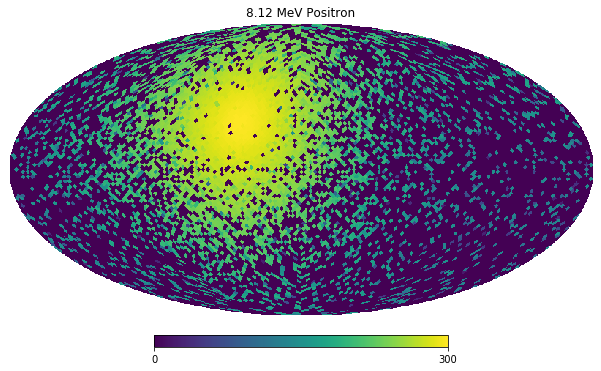

In [70]:
i=35 # E=8.12 R=15.3
ev1 = posPMT.pandas.df(entrystart=i, entrystop=i+1)
ev_noDN1 = no_DN(ev1)
ev_first1 = first(ev_noDN1)
ev_norm1 = normal_ft(ev_first1)
ev_map1 = mapev(ev_norm1)
cl1 = mollweide(ev_map1, i)

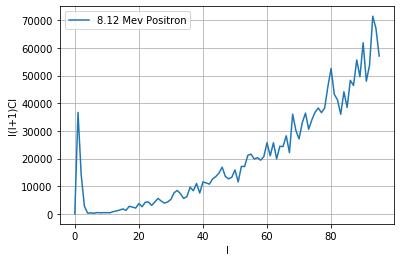

In [77]:
l1 = np.arange(len(cl1))
fig = plt.figure()
ax = fig.subplots()
ax.set_ylabel('l(l+1)Cl')
#ax.set_xlabel(r'$l$')
ax.set_xlabel('l')
plt.grid()
plt.plot(l1, l1 * (l1+1) * cl1, label='8.12 Mev Positron')
plt.legend()
#plt.savefig('/home/centos/pos_power.png')

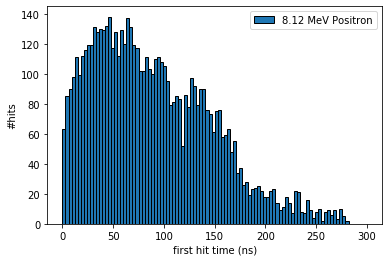

In [76]:
ev_time1 = ev_norm1['hitTime'].values
hist1 = bh.Histogram(bh.axis.Regular(100, 0, 300))
hist1.fill(ev_time1)
x = np.linspace(0, 300, 101)
fig = plt.figure()
ax = fig.subplots()
ax.set_ylabel('#hits')
ax.set_xlabel('first hit time (ns)')
plt.bar(x[:-1], hist1, width=np.diff(x), ec='black', align='edge', label='8.12 MeV Positron')
plt.legend()
#plt.savefig('/home/centos/pos_hist.png')

/home/centos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


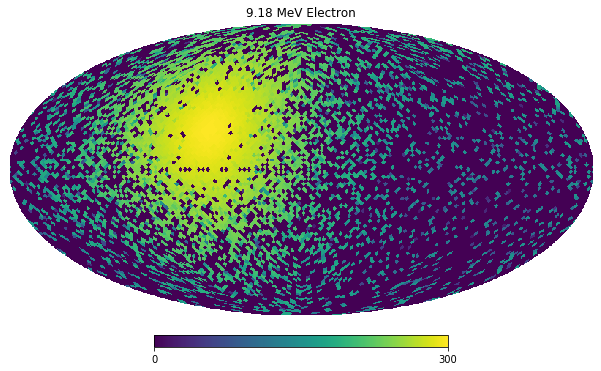

In [72]:
i=14959 # E=9.18 R=15.3
ev2 = elPMT.pandas.df(entrystart=i, entrystop=i+1)
ev_noDN2 = no_DN(ev2)
ev_first2 = first(ev_noDN2)
ev_norm2 = normal_ft(ev_first2)
ev_map2 = mapev(ev_norm2)
cl2 = mollweide(ev_map2, i)

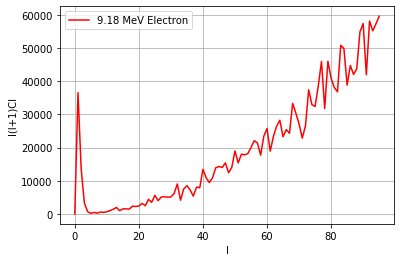

In [75]:
l2 = np.arange(len(cl2))
fig = plt.figure()
ax = fig.subplots()
ax.set_ylabel('l(l+1)Cl')
ax.set_xlabel('l')
plt.grid()
plt.plot(l2, l2 * (l2+1) * cl2, label='9.18 MeV Electron', color='red')
plt.legend() 
#plt.savefig('/home/centos/el_power.png')

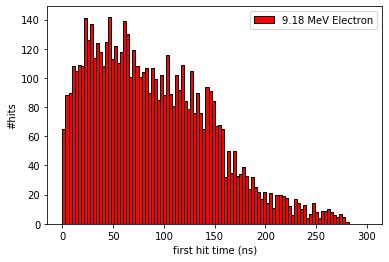

In [74]:
ev_time2 = ev_norm2['hitTime'].values
hist2 = bh.Histogram(bh.axis.Regular(100, 0, 300))
hist2.fill(ev_time2)
x = np.linspace(0, 300, 101)
fig = plt.figure()
ax = fig.subplots()
ax.set_ylabel('#hits')
ax.set_xlabel('first hit time (ns)')
plt.bar(x[:-1], hist2, width=np.diff(x), ec='black', align='edge', label='9.18 MeV Electron', color='red')
plt.legend()
#plt.savefig('/home/centos/el_hist.png') 